In [4]:
import numpy as np  
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import PolynomialFeatures
from itertools import product
import pandas as pd
import gradio as gr

def solve_ridge(Cxx, Cxy, regparam):
    return torch.linalg.solve(Cxx + regparam * torch.eye(Cxx.shape[0]), Cxy[:,None]).squeeze()

/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/blocks.py:219: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(
/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/blocks.py:219: UserWarning: api_name predict already exists, using predict_2
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


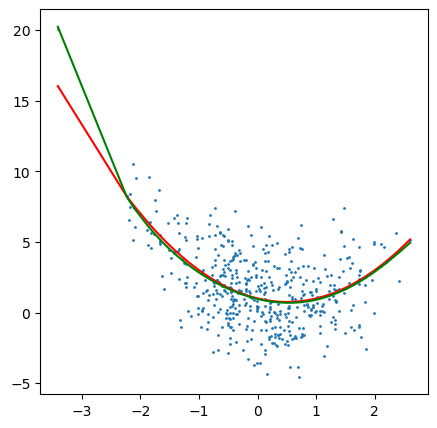

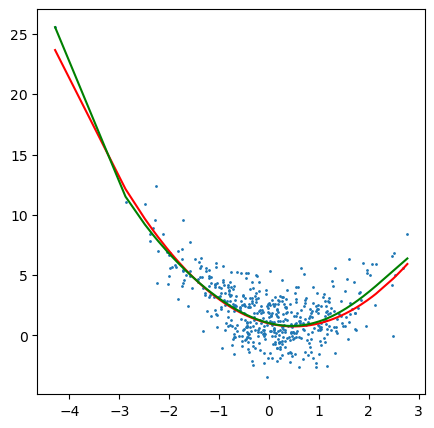

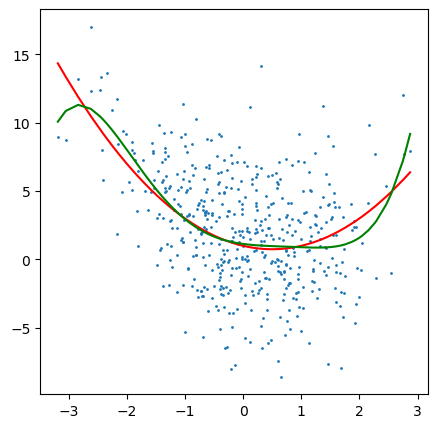

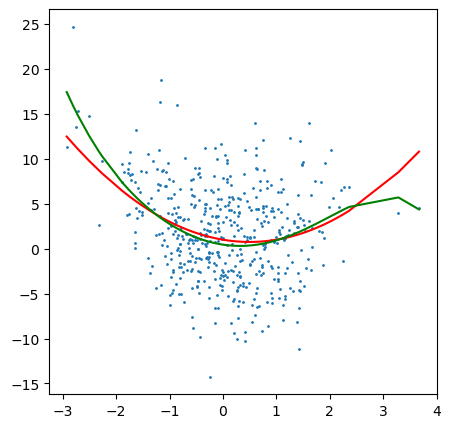

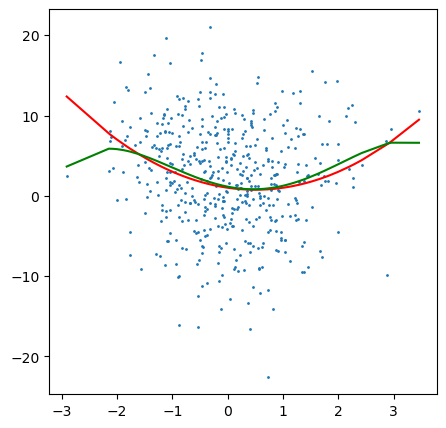

In [3]:
def process(n_train, degree, sig=1):
    X_train = torch.randn(n_train, 1)

    # Sort the data
    X_train, _ = torch.sort(X_train, dim=0)

    # Create a polynomial feature transformer
    poly = PolynomialFeatures(degree=degree)

    # Create polynomial features
    X = poly.fit_transform(X_train)
    X = torch.tensor(X, dtype=torch.float32)

    theta_tru = torch.tensor([1, -1, 1], dtype=torch.float32)*1
    theta_tru = torch.cat([theta_tru, torch.zeros(X.shape[1] - theta_tru.shape[0])])

    f_tru = X @ theta_tru
    y_train = f_tru + torch.randn(n_train) * sig
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)

    Cxx = X.T @ X / n_train # Covariance of X
    Cxy = X.T @ y_train / n_train # Cross covariance of X and y
    theta_ridge = solve_ridge(Cxx, Cxy, regparam = 0)

    f_ridge = X @ theta_ridge
     # Plot the data
    ax.scatter(X_train, y_train, s=1)
    ax.plot(X_train, f_tru, color='red')
    ax.plot(X_train, f_ridge, color='green')

    return fig

demo = gr.Interface(fn=process, 
                    inputs=[
                        gr.Number(value = 500, precision=0),
                        gr.Slider(2, 30, value=5, step=1, label="degree"),
                        gr.Slider(0, 10, value=1, step=0.25, label="noise s.d.")
                    ], 
                    outputs="plot", live=True)
demo.launch()

In [7]:
def show_mse(n_train, degree, sig, lamax):
    X_train = torch.randn(n_train, 1)

    # Sort the data
    X_train, _ = torch.sort(X_train, dim=0)

    # Create a polynomial feature transformer
    poly = PolynomialFeatures(degree=degree)

    # Create polynomial features
    X = poly.fit_transform(X_train)
    X = torch.tensor(X, dtype=torch.float32)

    # standardize the data
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    X[:,0] = 1

    theta_tru = torch.tensor([1, -1, 1], dtype=torch.float32)*1
    theta_tru = torch.cat([theta_tru, torch.zeros(X.shape[1] - theta_tru.shape[0])])

    f_tru = X @ theta_tru
   
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)

    Cxx = X.T @ X / n_train # Covariance of X

    n_reps = 50
    n_regparams = 100
    regparams = np.logspace(-4, lamax, n_regparams)
    res = []
    for rep, regparam in product(range(n_reps), regparams):
        y_train = f_tru + torch.randn(n_train) * sig
        
        Cxy = X.T @ y_train / n_train
        theta_ridge = solve_ridge(Cxx, Cxy, regparam)
        f_ridge = X @ theta_ridge
        # loss = torch.mean((f_ridge - y_train)**2).item()
        loss = torch.mean((f_tru - f_ridge)**2).item()
        # store rep, regparam, loss
        res.append({'rep':rep, 'regparam':regparam, 'loss':loss})

    res = pd.DataFrame(res)

    # average over repetitions
    res = res.groupby('regparam').mean().reset_index()

    # plot the results
    ax.plot(res.regparam, res.loss)
    #plt.xscale('log')

    # svd of X
    U, S, V = torch.linalg.svd(X / np.sqrt(n_train), full_matrices=False)
    U.shape, S.shape, V.shape

    xi_tru = U.T @ f_tru / np.sqrt(n_train)
    mu = S**2


    def get_theor_mse(regparam):
        Gamma = torch.diag(mu / (mu + regparam))
        z = (torch.eye(Gamma.shape[0]) - Gamma) @ xi_tru
        bias = (z**2).sum()
        variance = (sig**2 / n_train) * torch.trace(Gamma**2)
        return bias + variance

    # theor_mses = torch.zeros_like(regparams)
    ax.plot(regparams, [get_theor_mse(regparam) for regparam in regparams])


    return fig

demo = gr.Interface(fn=show_mse, 
                    inputs=[
                        gr.Number(value = 500, precision=0),
                        gr.Slider(2, 30, value=5, step=1, label="degree"),
                        gr.Slider(0, 10, value=1, step=0.1, label="noise s.d."),
                        gr.Slider(-3, 2, value=-1, step=0.25, label="max log lambda")
                    ], 
                    outputs="plot", live=True, allow_flagging = False)
demo.launch()

/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/interface.py:333: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(
/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/blocks.py:228: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(
/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/blocks.py:228: UserWarning: api_name predict already exists, using predict_2
  warnings.warn(
/Users/arash/miniforge3/envs/torch/lib/python3.8/site-packages/gradio/blocks.py:228: UserWarning: api_name predict already exists, using predict_3
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


/var/folders/ch/6ry9wgx50_gg8_tlzdcdv58w0000gn/T/ipykernel_14899/3386956179.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5, 5))


tensor([[    nan, -2.8219,  4.9731, -6.2130,  7.8800, -8.9894],
        [    nan, -2.6334,  4.2365, -5.0387,  5.8785, -6.3381],
        [    nan, -2.6133,  4.1610, -4.9229,  5.6888, -6.0967],
        ...,
        [    nan,  2.3886,  3.4110,  3.9063,  3.9645,  4.1213],
        [    nan,  2.5642,  4.0381,  4.8195,  5.3867,  5.8423],
        [    nan,  2.6476,  4.3517,  5.2999,  6.1733,  6.8429]])


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 5).

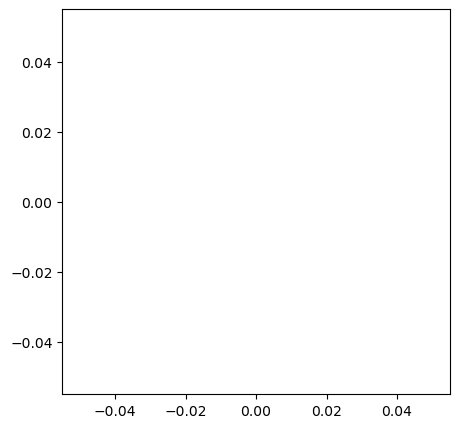

In [54]:
process(500, 5, 1, -1)